In [74]:
!pip install psycopg2

In [75]:
import psycopg2 as ps
import psycopg2.extras as e
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools as iter

In [76]:

PATH_SPLIT_DATA='C:\\Users\\Public\\CS645\\see_db_dataset\\splits'

def split_data(splits):
    data_raw = pd.read_csv(r'C:\\Users\\Public\\CS645\\see_db_dataset\\adult.txt')
    data_split = np.array_split(data_raw, splits)
    for k in range(1, len(data_split)+1):
        data_split[k-1].to_csv(os.path.join(PATH_SPLIT_DATA ,"split_{}.csv".format(k)),encoding='utf-8', index=False)

split_data(10)

In [77]:
con = ps.connect("dbname='see_db' user='postgres' host='localhost' password='bluemoon0512'")
curs = con.cursor()

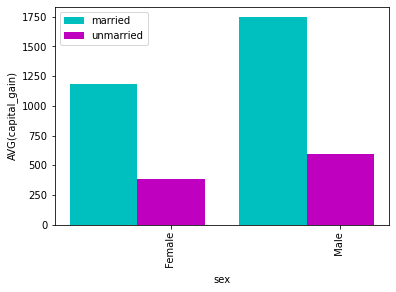

In [78]:
curs.execute("""create or replace view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
           create or replace view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');""")
con.commit()

curs.execute("select sex, avg(capital_gain) from married group by sex;")
target = curs.fetchall()

curs.execute("select sex, avg(capital_gain) from unmarried group by sex;")
reference = curs.fetchall()

def create_plot(afm, reference, target):
    group_attr,function, measure = afm
    plt.subplots()
    graph1 = plt.bar(np.arange(len(target)), target.values(), 0.4, color = 'c', label = 'married')
    graph2 = plt.bar(np.arange(len(target))+0.4, reference.values(), 0.4, color = 'm', label = 'unmarried')
    
    plt.xlabel('{}'.format(group_attr))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(np.arange(len(target))+0.4, target.keys(), rotation=90)
    plt.legend()

    plt.show()

afm_plot = ('sex', 'AVG', 'capital_gain')
create_plot(afm_plot, dict(reference), dict(target))

In [79]:
def normalize(data):
    return data.reshape(-1)

#K-L divergence
def kl_divergence(ref_data, tar_data):
    ref_nor = normalize(ref_data)
    tar_nor = normalize(tar_data)
#     if sum(ref_nor) < 0 or sum(tar_nor) < 0:
#         return 0
    pro_ref = [i/np.sum(ref_nor) for i in ref_nor if sum(ref_nor)>0]
    pro_tar = [i/np.sum(tar_nor) for i in tar_nor if sum(tar_nor)>0]
    kl = np.sum([qi  * np.log(qi/pi) for qi, pi in zip(pro_tar, pro_ref) if pi>0 and qi>0])
    return kl

In [80]:
#phased execution

for i in range(10):
    curs.execute("""create or replace view test{}_married as 
                   select * from test{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view test{}_unmarried as 
                   select * from test{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1))
    con.commit()

In [81]:
funcs = ['sum', 'count', 'avg', 'min', 'max']
group_by_col = ["economic_indicator", "workclass", "occupation", "education", "race", "native_country", "sex", "relationship"]
measure_col = ["capital_loss", "capital_gain", "age", "fnlwgt", "hours_per_week"]

views = {pos:combo for pos, combo in enumerate(list(iter.product(funcs, measure_col, group_by_col)))}
tables = ['married', 'unmarried']

In [82]:
def share_based_optimization(tables, views, phase):
    print("in share_based_optimization")
    kl_dict={}
    for table in tables:
        for i, (f, m, a) in views.items():
            query="create or replace view vi_{} as select {}, {}({}) from test{}_{} group by {};".format(table+"_"+str(i),a,f,m,phase,table,a)
            curs.execute(query)
            con.commit()
            kl_dict[f+"-"+m+"-"+a]=["vi_"+str(table+"_"+str(i))]
    print("done")
    return kl_dict


In [83]:
def get_views_scores(views, curs):
    print("running get view scores...")
    views_scores = dict()

    for vid, (f, m, a) in views.items():
        tgt_sql_query = 'SELECT * FROM vi_unmarried_{}'.format(vid)
        curs.execute(tgt_sql_query)
        data = curs.fetchall()
        cols = [desc[0] for desc in curs.description]
        tgt_df = pd.DataFrame(data, columns=cols)


        ref_sql_query = 'SELECT * FROM vi_married_{}'.format(vid)
        curs.execute(ref_sql_query)
        data = curs.fetchall()
        cols = [desc[0] for desc in curs.description]
        ref_df = pd.DataFrame(data, columns=cols)

        temp_df = tgt_df.join(ref_df.set_index(a), on=a, how='inner', lsuffix='_target', rsuffix='_reference')
        

        tgt_val = temp_df['{}_target'.format(f)].values
        ref_val = temp_df['{}_reference'.format(f)].values

        score = kl_divergence(tgt_val, ref_val)
        views_scores[vid] = score
    print("done")
    return views_scores


In [84]:
def pruning(views, phase):
    delta = 0.05
    N = 10
    K = 5
#     for i in range(10):
    print("Pruning for i = " + str(i))
    m = i+1
    if m == 1:
        return views
    eps = np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))
    current_scores = get_views_scores(views, curs)
    sorted_scores = {k: v for k, v in sorted(current_scores.items(), key=lambda item: item[1], reverse=True)}
    
    top_k_smallest_lower_bound = np.mean(list(sorted_scores.values())[K]) - eps
#         values = list(current_scores.values())
#         mu = sum(values)/len(values)
#         confidence_interval
    
    for k, v in sorted_scores.items():
        if np.mean(v) + eps < top_k_smallest_lower_bound:
            print("deleting view " + str(k))
            del views[k]
    return views

In [85]:
current_views = views
for i in range(10):
    kl_dicts = share_based_optimization(tables, current_views, i+1)
    pruning(current_views, i+1)

in share_based_optimization
done
Pruning for i = 0
in share_based_optimization
done
Pruning for i = 1
running get view scores...
done
in share_based_optimization
done
Pruning for i = 2
running get view scores...
done
in share_based_optimization
done
Pruning for i = 3
running get view scores...
done
in share_based_optimization
done
Pruning for i = 4
running get view scores...
done
in share_based_optimization
done
Pruning for i = 5
running get view scores...
done
in share_based_optimization
done
Pruning for i = 6
running get view scores...
done
deleting view 25
deleting view 33
deleting view 105
deleting view 189
deleting view 41
deleting view 49
deleting view 57
deleting view 65
deleting view 73
deleting view 3
deleting view 109
deleting view 17
deleting view 27
deleting view 197
deleting view 191
deleting view 43
deleting view 51
deleting view 59
deleting view 67
deleting view 75
deleting view 185
deleting view 158
deleting view 181
deleting view 177
deleting view 13
deleting view 117


In [86]:
# get top 5 views
current_scores = get_views_scores(current_views, curs)
top_views = {k: v for k, v in sorted(current_scores.items(), key=lambda item: item[1], reverse=True)[:20]}
top_views
for tp in top_views:
    print(current_views[tp])

running get view scores...
done
('max', 'capital_loss', 'relationship')
('avg', 'capital_loss', 'relationship')
('max', 'capital_gain', 'native_country')
('sum', 'capital_loss', 'sex')
('sum', 'capital_loss', 'relationship')
('sum', 'capital_loss', 'economic_indicator')
('sum', 'fnlwgt', 'economic_indicator')
('min', 'hours_per_week', 'education')
('count', 'capital_loss', 'economic_indicator')
('count', 'capital_gain', 'economic_indicator')
('count', 'age', 'economic_indicator')
('count', 'fnlwgt', 'economic_indicator')
('count', 'hours_per_week', 'economic_indicator')
('sum', 'hours_per_week', 'economic_indicator')
('min', 'hours_per_week', 'workclass')
('sum', 'age', 'economic_indicator')
('max', 'capital_gain', 'workclass')
('avg', 'capital_loss', 'workclass')
('sum', 'age', 'sex')
('min', 'hours_per_week', 'relationship')


In [87]:
current_scores

{0: 0.5793883411727253,
 2: 0.2970216579051611,
 6: 0.6361990515201154,
 7: 0.6282333135025839,
 10: 0.2475457902043879,
 16: 0.39777497371851395,
 22: 0.3695875245646967,
 24: 0.4769177181773987,
 30: 0.2662266601753386,
 32: 0.44904004526852787,
 38: 0.30358058145521094,
 40: 0.4608517425508649,
 46: 0.2959085852277491,
 48: 0.4608517425508649,
 54: 0.2959085852277491,
 56: 0.4608517425508649,
 62: 0.2959085852277491,
 64: 0.4608517425508649,
 70: 0.2959085852277491,
 72: 0.4608517425508649,
 78: 0.2959085852277491,
 81: 0.38000845468809996,
 87: 1.317815325098987,
 90: 0.25342543963906144,
 153: 0.4059155490126097,
 155: 0.46740785486021497,
 159: 0.35539909505546124,
 167: 1.4126783498232531,
 169: 0.3901261655349658,
 170: 0.3487027182995522,
 173: 0.8976242589976362,
 175: 0.2659514921265652}

In [88]:
def print_top_views(top_views):
    for tp in top_views:
        f, m, a = current_views[tp]
        query = "SELECT {}, {}({}) FROM married GROUP BY {};".format(a, f, m, a)
        curs.execute(query)
        target_table = curs.fetchall()
        
        query = "SELECT {}, {}({}) FROM unmarried GROUP BY {};".format(a, f, m, a)
        curs.execute(query)
        reference_table = curs.fetchall()
        
        tgt_dict = dict(target_table)
        ref_dict = dict(reference_table)

        for k in tgt_dict.keys():
            if k not in ref_dict:
                ref_dict[k] = 0

        for k in ref_dict.keys():
            if k not in tgt_dict:
                tgt_dict[k] = 0
        
        create_plot((a,f,m), ref_dict, tgt_dict)

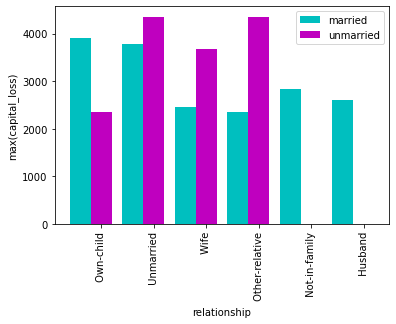

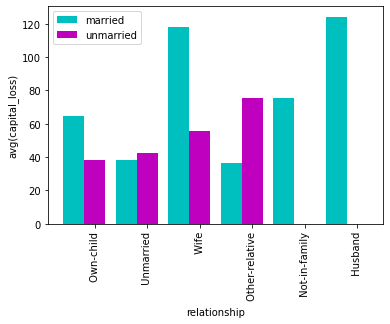

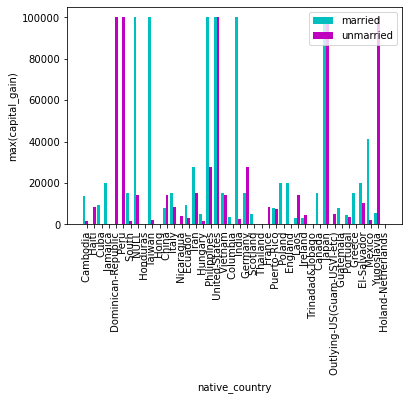

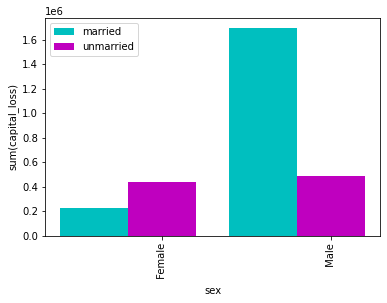

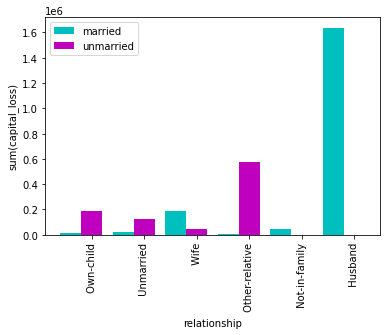

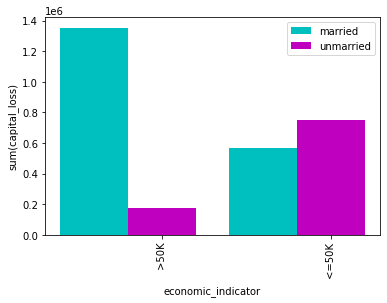

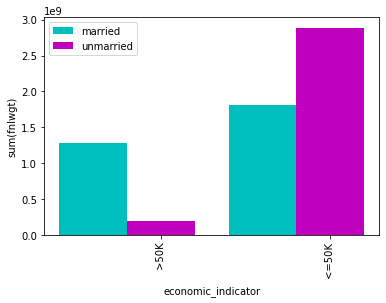

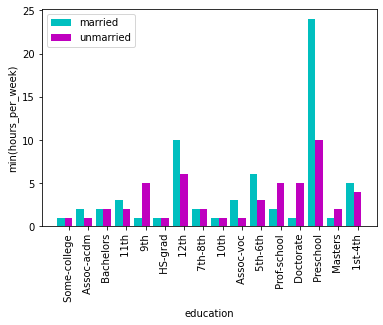

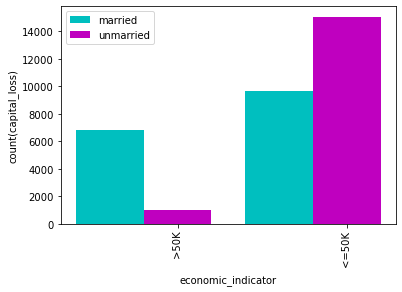

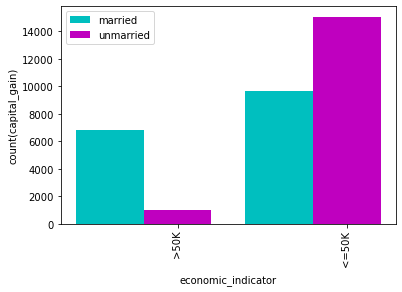

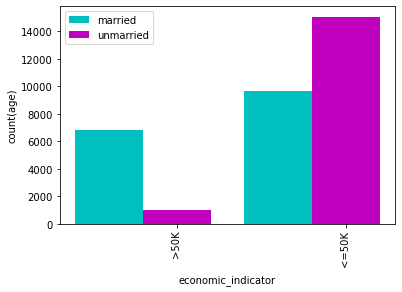

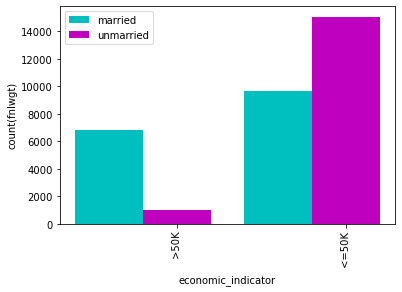

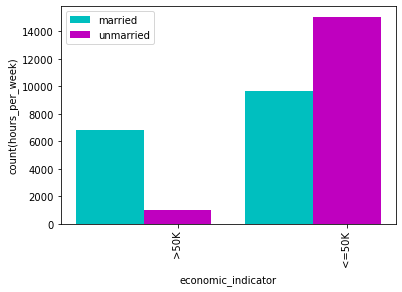

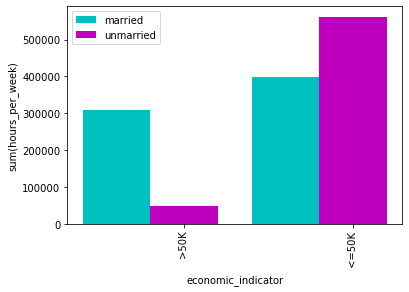

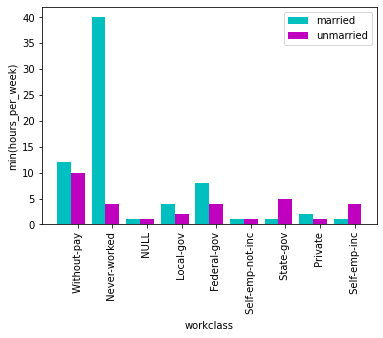

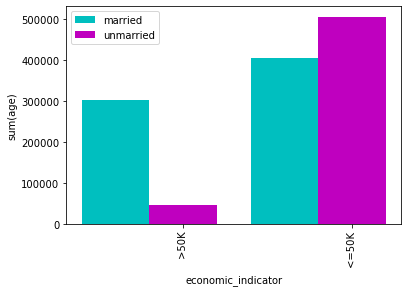

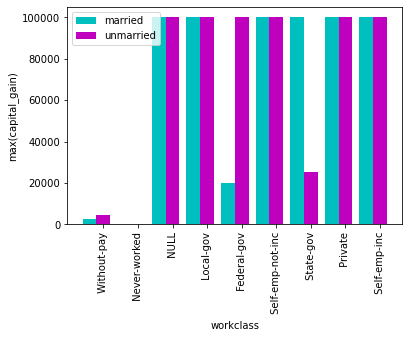

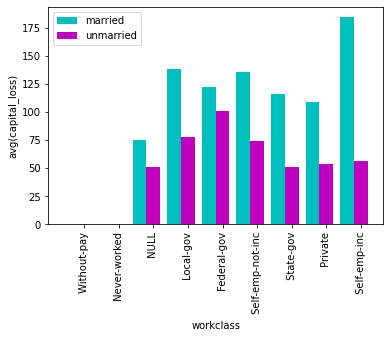

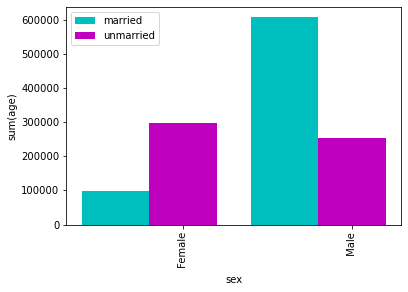

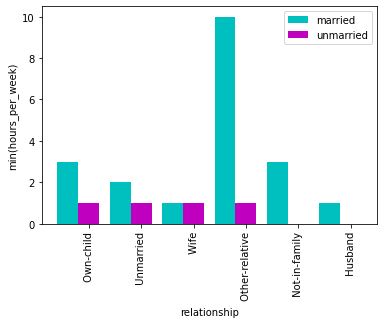

In [89]:
print_top_views(top_views)